# White Blood Cells Classification with Deep Learning - Model Garden

An exploration of different models for white blood cells classification.


## Dataset

The data is available as a kaggle dataset, https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset, as a copy of the original dataset by A. Acevedo _et al._: [_A dataset for microscopic peripheral blood cell images for development of automatic recognition systems_](https://data.mendeley.com/datasets/snkd93bnjr/1).


## Load dependencies


In [30]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import altair as alt
from pathlib import Path
import sklearn
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
data_dir = Path("../data/bloodcells_dataset")

In [32]:
batch_size = 32
epochs = 10
img_width = 224
img_height = 224

## Loading the dataset


In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds_tuned = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_tuned = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Found 17092 files belonging to 8 classes.
Using 3418 files for validation.


In [34]:
class_names = train_ds.class_names
print("Here are the class names of the dataset: ")
print("", *class_names, sep="\n * ")

Here are the class names of the dataset: 

 * basophil
 * eosinophil
 * erythroblast
 * ig
 * lymphocyte
 * monocyte
 * neutrophil
 * platelet


## Visualizing the data


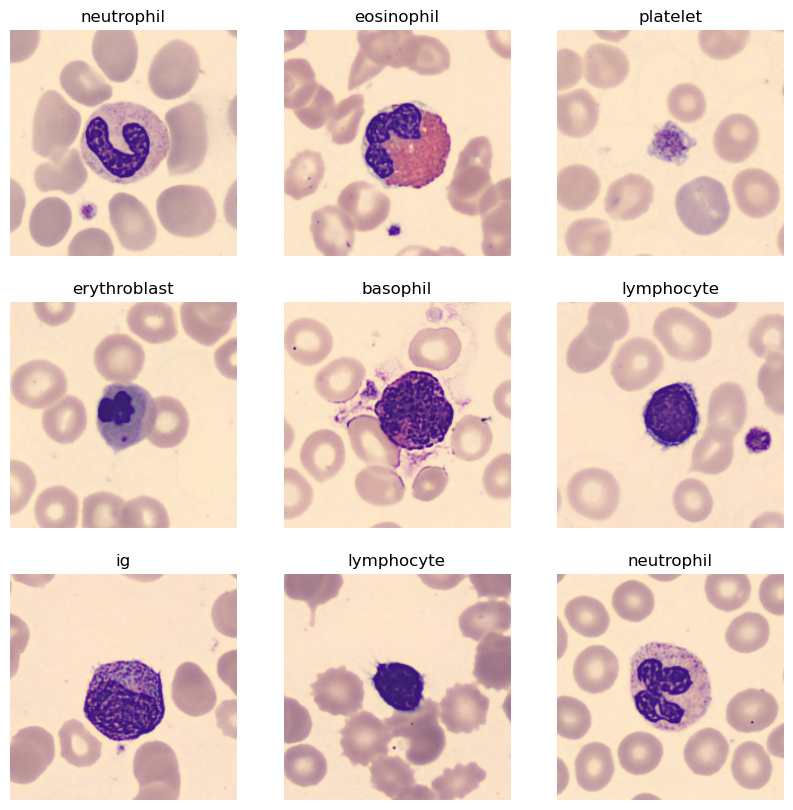

In [35]:
plt.figure(figsize=(10, 10))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Garden Model


In [36]:
num_classes = len(class_names)


### Classic CNN


Let's declare a base CNN model:


In [37]:
# Model structure
cnn_model_1 = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(img_height, img_width, 3)),
        tf.keras.layers.Rescaling(1.0 / 255),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes),
    ]
)

# Compile the model
cnn_model_1.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Model summary
cnn_model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 54, 54, 32)       

Training the model using the training dataset...


In [38]:
cnn_model_1.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/10
428/428 [==============================] - 196s 455ms/step - loss: 0.9575 - accuracy: 0.6672 - val_loss: 0.5718 - val_accuracy: 0.7738
Epoch 2/10
428/428 [==============================] - 192s 449ms/step - loss: 0.3214 - accuracy: 0.8869 - val_loss: 0.2864 - val_accuracy: 0.8991
Epoch 3/10
428/428 [==============================] - 191s 445ms/step - loss: 0.2075 - accuracy: 0.9282 - val_loss: 0.3365 - val_accuracy: 0.8836
Epoch 4/10
428/428 [==============================] - 190s 444ms/step - loss: 0.1452 - accuracy: 0.9506 - val_loss: 0.3237 - val_accuracy: 0.8912
Epoch 5/10
428/428 [==============================] - 189s 441ms/step - loss: 0.1456 - accuracy: 0.9491 - val_loss: 0.3858 - val_accuracy: 0.8812
Epoch 6/10
428/428 [==============================] - 190s 444ms/step - loss: 0.0800 - accuracy: 0.9736 - val_loss: 0.4130 - val_accuracy: 0.8815
Epoch 7/10
428/428 [==============================] - 189s 441ms/step - loss: 0.0649 - accuracy: 0.9782 - val_loss: 0.4732 -

#### Model evaluation


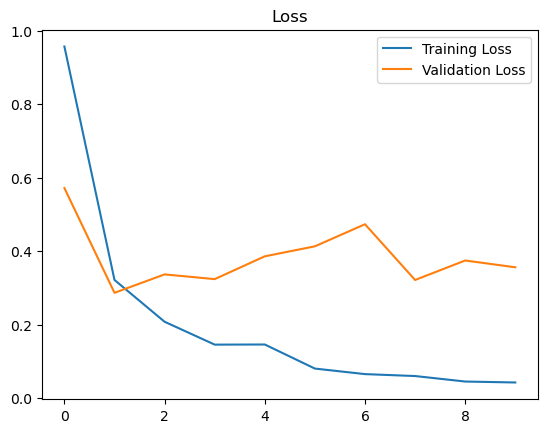

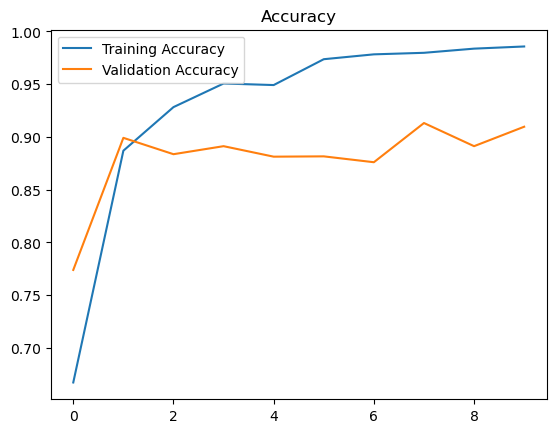

In [39]:
history = cnn_model_1.history.history

train_loss = history["loss"]
val_loss = history["val_loss"]
train_acc = history["accuracy"]
val_acc = history["val_accuracy"]

# Loss
plt.figure()
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss")
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

Using tensorflow model hub:

### EfficientNetB0


In [40]:
# efficient_net_model_1 = tf.keras.Sequential([
#     hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/classification/1")
# ])
# efficient_net_model_1.build([None, img_width, img_height, 3])


In [41]:
from tensorflow.keras.applications import EfficientNetB0

# inputs = tf.keras.layers.Input(shape=(img_width, img_height, 3))
# outputs = EfficientNetB0(include_top=True, weights=None, classes=num_classes)(
#     inputs
# )

# model = tf.keras.Model(inputs, outputs)
# model.compile(
#     optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
# )

# model.summary()

efficient_net_model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(img_width, img_height, 3)),
        EfficientNetB0(include_top=True, weights=None, classes=num_classes),
    ]
)
efficient_net_model_1.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
epochs = 40  # @param {type: "slider", min:10, max:100}
efficient_net_model_1.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

Epoch 1/40


ValueError: in user code:

    File "/home/sortion/.local/share/mambaforge/envs/blood-cell-classifier/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/sortion/.local/share/mambaforge/envs/blood-cell-classifier/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/sortion/.local/share/mambaforge/envs/blood-cell-classifier/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/sortion/.local/share/mambaforge/envs/blood-cell-classifier/lib/python3.11/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/sortion/.local/share/mambaforge/envs/blood-cell-classifier/lib/python3.11/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/home/sortion/.local/share/mambaforge/envs/blood-cell-classifier/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/sortion/.local/share/mambaforge/envs/blood-cell-classifier/lib/python3.11/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/sortion/.local/share/mambaforge/envs/blood-cell-classifier/lib/python3.11/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/sortion/.local/share/mambaforge/envs/blood-cell-classifier/lib/python3.11/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/sortion/.local/share/mambaforge/envs/blood-cell-classifier/lib/python3.11/site-packages/keras/src/backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 8) are incompatible


## References

- <https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/>
